<a href="https://www.kaggle.com/code/hawaabdalla/k-means-pca-mall-customer-segmentation?scriptVersionId=116972753" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [17]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

##### Overview of the whole dataset
##### The data had no missing values

In [2]:
data= pd.read_csv("/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")
print("data shape:", data.shape)
print(data.info())
data.head()

data shape: (200, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


##### Data Cleaning: 
duplicates, dropping the high cardinality feature (CustomerID) and Gender( categorical variable not handled by k means model).

In [3]:
data.duplicated()
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 9.4+ KB


In [4]:
# Dropping the columns "Gender"and "CustomerID"
data.drop(["Gender","CustomerID"], axis="columns",inplace=True)
data.head(5)

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


##### Data Exploration

 Correlation between features in the dataframe
 Age is negatively correlated with the rest of the variables
 Spending score is minimally correlated with Annual Income

In [5]:
cols = ["Age","Annual Income (k$)","Spending Score (1-100)"]
corr = data[cols].corr()
corr.style.background_gradient(axis=None)

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,-0.012398,-0.327227
Annual Income (k$),-0.012398,1.000000,0.009903
Spending Score (1-100),-0.327227,0.009903,1.000000


##### From the figure below we can see that the age values are distributed across a large range

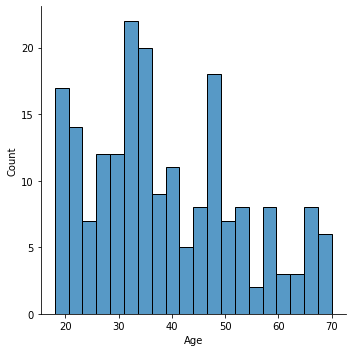

In [6]:
sns.displot(data['Age'], bins=20)

##### Split the data into feature matrix

In [7]:
x= data[["Age", "Annual Income (k$)", "Spending Score (1-100)"]]
x.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


##### Building the model and calculating the scores 

In [8]:
n_clusters = range(2,13)
inertia_errors = []
silhouette_scores = []

#Add for loop to train the model and calculate inertia, silhouette score
for k in n_clusters:
    #Build the model
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    #Train the model
    model.fit(x)
    #Calculate inertia
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    #Calculate silhoutte
    silhouette_scores.append(
        silhouette_score(x, model.named_steps["kmeans"].labels_)
    )
print("Inertia:", inertia_errors[:3])
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [389.3861889564372, 295.2122461555488, 205.22514747675913]
Silhouette Scores: [0.276257743689132, 0.30330733715429475, 0.3825939315551745]


##### Elbow method to find the optimal clusters
To determine the optimal number of clusters for K-Prototype,the elbow method is used.It is a backnone to a well formed clustering algorithm. The method plots the value of the cost function produced by different values of k.If k increases, the average distortion decreases,making each cluster have fewer constituent instances, and the instances will be closer to their respective centroids.

However, the improvements in average distortion will decline as k increases. The value of k at which improvement in distortion declines the most is called the elbow, at which we should stop dividing the data into further clusters
From the figure below we can pick cluster k=6 as the optimal number of clusters

In [9]:
fig = px.line(x=n_clusters, y=inertia_errors, title="K-Means model: Inertia vs Number of Clusters")
fig.show()

 Building the final model using k=6 as the optimal number of clusters,ie the point at the "elbow" or the point at which the cost start decreasing in a linear fashion.

In [10]:
final_model = make_pipeline(StandardScaler(), KMeans(n_clusters=6, random_state=42))
final_model.fit(x)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=6, random_state=42))])

##### Extracting the centroids and labels

In [11]:
labels= final_model.named_steps["kmeans"].labels_
print(labels[:5])

[0 0 5 0 5]


In [12]:
centroids= final_model.named_steps["kmeans"].cluster_centers_
centroids

array([[-0.99396865, -1.34734766,  1.06404834],
       [ 1.25472096, -0.24021294, -0.04399777],
       [ 0.22171558,  1.08322527, -1.29005223],
       [-0.86515664, -0.13196835, -0.08043031],
       [-0.44191719,  0.99158305,  1.23950275],
       [ 0.47895722, -1.30822992, -1.19644353]])

 Creating a DataFrame df which contains the mean values of the features in x, for each of the clusters in the final_model

In [13]:
df= x.groupby(labels).mean()
df

,Age,Annual Income (k$),Spending Score (1-100)
0,25.000000,25.260870,77.608696
1,56.333333,54.266667,49.066667
2,41.939394,88.939394,16.969697
3,26.794872,57.102564,48.128205
4,32.692308,86.538462,82.128205
5,45.523810,26.285714,19.380952


##### Visualizing the df using a side-by-side bar chart

In [14]:
fig= px.bar(
    df,barmode="group",title="Mean of customer data by cluster"
)
fig.show()

##### Principal Component Analysis (PCA):
To reduce dimensionality of the data. We are picking the lowest number as possible, which is 2

In [15]:
# Instantiate transformer
pca = PCA(n_components=2, random_state=42)

#Transform x
XT = pca.fit_transform(x)

#Put XT into a DataFrame
Xpca= pd.DataFrame(XT, columns=["PC1", "PC2"])

print("Xpca shape:", Xpca.shape)
Xpca.head()

Xpca shape: (200, 2)


,PC1,PC2
0,-31.870508,-33.001425
1,0.763397,-56.843865
2,-57.408726,-13.122936
3,-2.169896,-53.477905
4,-32.174920,-30.387005


##### Creating a scatter plot to visualize the clusters in the Reduced Dimension.

In [16]:
fig= px.scatter(
    data_frame= Xpca,
    x= "PC1",
    y= "PC2",
    color=labels.astype(str),
    title= "PCA Representation of Clusters"  
)
fig.update_layout(xaxis_title="PC1", yaxis_title="PC2")
fig.show()